In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.stats import boxcox

from imp import load_source

from sklearn.decomposition import PCA

import aggregate_player_stats as aps

query_strings = load_source('query_strings', '../stats_generation/query_strings.py' )
gps = load_source(  'generate_player_stats', '../stats_generation/generate_player_stats.py' )

In [2]:
%matplotlib inline
plt.style.use('dark_background')
from pylab import rcParams
rcParams['figure.figsize'] = 14, 10

Generate stuff for whole team

In [3]:
team_stats_df = aps.generate_full_team_aggregate( 2017, drop_preseason=False )

In [4]:
print team_stats_df.shape
print team_stats_df.columns.values

(5132, 71)
[u'team' 'opp_team' u'week' 'year' 'score' 'opp_score' 'home_flag'
 'away_flag' 'tds' u'rush_att' u'rush_yds' u'pass_att' u'pass_yds'
 u'pass_cmp' u'pass_sack' u'kickoffs' u'punts' u'fg_miss' u'kickret_tds'
 u'punt_ret_tds' u'off_fumb_tot' u'kickoff_in_20' u'kickoff_touchback'
 u'fg_yds' u'fg_made' u'def_int_tds' u'def_frec_tds' u'def_misc_tds'
 u'def_safety' u'def_tkl' u'def_tkl_contributers' u'def_fumb_rec'
 u'def_fumb_forced' u'def_int' u'def_tkl_loss' u'def_sack' u'def_pass_def'
 'score_prev_4' 'opp_score_prev_4' 'home_flag_prev_4' 'away_flag_prev_4'
 'tds_prev_4' 'rush_att_prev_4' 'rush_yds_prev_4' 'pass_att_prev_4'
 'pass_yds_prev_4' 'pass_cmp_prev_4' 'pass_sack_prev_4' 'kickoffs_prev_4'
 'punts_prev_4' 'fg_miss_prev_4' 'kickret_tds_prev_4' 'punt_ret_tds_prev_4'
 'off_fumb_tot_prev_4' 'kickoff_in_20_prev_4' 'kickoff_touchback_prev_4'
 'fg_yds_prev_4' 'fg_made_prev_4' 'def_int_tds_prev_4'
 'def_frec_tds_prev_4' 'def_misc_tds_prev_4' 'def_safety_prev_4'
 'def_tkl_prev_4'

RB include most individual stats

In [4]:
n_weeks  = 4
min_year = 2009
max_year = 2017
wk_str   = str(n_weeks)

all_rb_data = pd.DataFrame()

# Get all the preseason data
# Can id by team, week, year
for year in range( min_year, max_year ):
    new_frame = gps.generate_stats( 'RB', year, season_type='Preseason' )
    new_frame['year'] = year
    all_rb_data = pd.concat( [all_rb_data, new_frame], ignore_index=True )

    
all_rb_data['week'] = all_rb_data['week']-4
    

# Get all the RB regular season data
# Can id by team, week, year
for year in range( min_year, max_year ):
    new_frame = gps.generate_stats( 'RB', year )
    new_frame['year'] = year
    all_rb_data = pd.concat( [all_rb_data, new_frame], ignore_index=True )
    
    
# Ignore some team stuff, can get from joining with team
all_rb_data = all_rb_data.drop( ['opp_team','home_flag','away_flag'],axis=1 )

# Generate previous rolling sum
agg_stuff = [
                'receptions',
                'rec_target', 
                'rec_yds',
                'rec_tds', 
                'rush_att', 
                'rush_yds', 
                'rush_tds', 
                'fumb_lost',
                'fumb_rec', 
                'fumb_rec_tds', 
                'fumb_forced', 
                'fumb_nforced',
                'yards_after_compl', 
                'return_yds', 
                'return_tds',
                'touchbacks'
            ]
prev_rb = aps.calc_prev_player_stats( all_rb_data, agg_stuff )

# Combine present values with rolling sums
all_rb_data = pd.merge( all_rb_data, prev_rb, on=['player_id','year','week'] )

# Drop all the preseason stuff
all_rb_data = all_rb_data.loc[ all_rb_data['week']>0 ]

# Note if the data includes preseason stuff
# If the first four games, flag as preseason data included
# This is tricky, as can have a bye-week
# Therefore, group things, find the first n_weeks, and flag those as 1
inds = all_rb_data.groupby(['player_id','year'], as_index=False).nth( range(0, n_weeks) ).index.values

all_rb_data    [       'few_reg_weeks'] = 0
all_rb_data.loc[ inds, 'few_reg_weeks'] = 1

In [5]:
all_rb_data.columns.values

array([u'player_id', u'team', u'week', u'receptions', u'rec_yds',
       u'rec_tds', u'rush_att', u'rush_yds', u'rush_tds', u'fumb_lost',
       u'fumb_rec_tds', u'fumb_rec', u'fumb_forced', u'fumb_nforced',
       u'rec_target', u'yards_after_compl', u'return_yds', u'return_tds',
       u'touchbacks', 'year', 'receptions_prev_4', 'rec_target_prev_4',
       'rec_yds_prev_4', 'rec_tds_prev_4', 'rush_att_prev_4',
       'rush_yds_prev_4', 'rush_tds_prev_4', 'fumb_lost_prev_4',
       'fumb_rec_prev_4', 'fumb_rec_tds_prev_4', 'fumb_forced_prev_4',
       'fumb_nforced_prev_4', 'yards_after_compl_prev_4',
       'return_yds_prev_4', 'return_tds_prev_4', 'touchbacks_prev_4',
       'few_reg_weeks'], dtype=object)

In [6]:
print all_rb_data.shape
print all_rb_data.columns.values

(5403, 37)
[u'player_id' u'team' u'week' u'receptions' u'rec_yds' u'rec_tds'
 u'rush_att' u'rush_yds' u'rush_tds' u'fumb_lost' u'fumb_rec_tds'
 u'fumb_rec' u'fumb_forced' u'fumb_nforced' u'rec_target'
 u'yards_after_compl' u'return_yds' u'return_tds' u'touchbacks' 'year'
 'receptions_prev_4' 'rec_target_prev_4' 'rec_yds_prev_4' 'rec_tds_prev_4'
 'rush_att_prev_4' 'rush_yds_prev_4' 'rush_tds_prev_4' 'fumb_lost_prev_4'
 'fumb_rec_prev_4' 'fumb_rec_tds_prev_4' 'fumb_forced_prev_4'
 'fumb_nforced_prev_4' 'yards_after_compl_prev_4' 'return_yds_prev_4'
 'return_tds_prev_4' 'touchbacks_prev_4' 'few_reg_weeks']


In [7]:
all_rb_data.head()

,player_id,team,week,receptions,rec_yds,rec_tds,rush_att,rush_yds,rush_tds,fumb_lost,...,fumb_lost_prev_4,fumb_rec_prev_4,fumb_rec_tds_prev_4,fumb_forced_prev_4,fumb_nforced_prev_4,yards_after_compl_prev_4,return_yds_prev_4,return_tds_prev_4,touchbacks_prev_4,few_reg_weeks
1490,00-0022999,GB,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1491,00-0022999,GB,2,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1492,00-0022999,GB,3,1,10,1,1,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1493,00-0022999,GB,4,0,0,0,2,5,0,0,...,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,1
1494,00-0022999,GB,6,1,1,1,1,2,0,0,...,0.0,1.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0


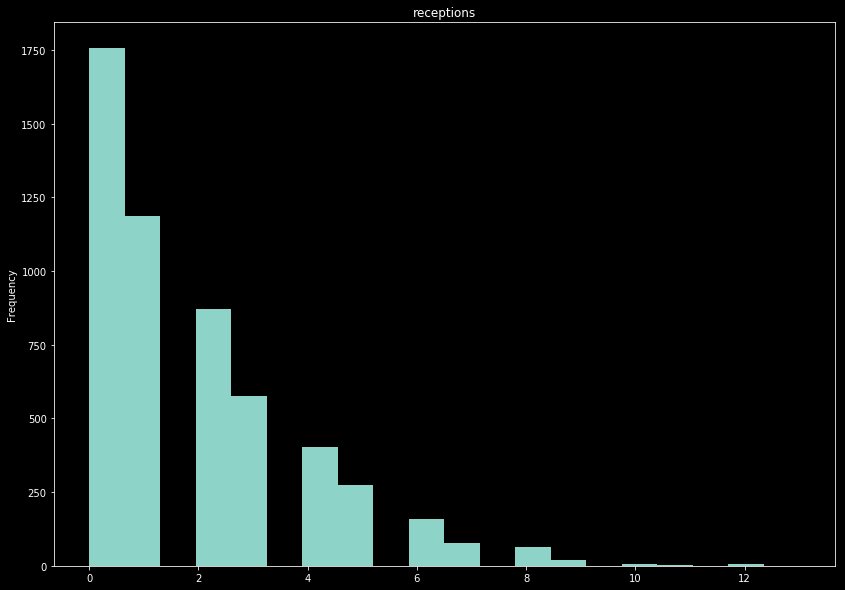

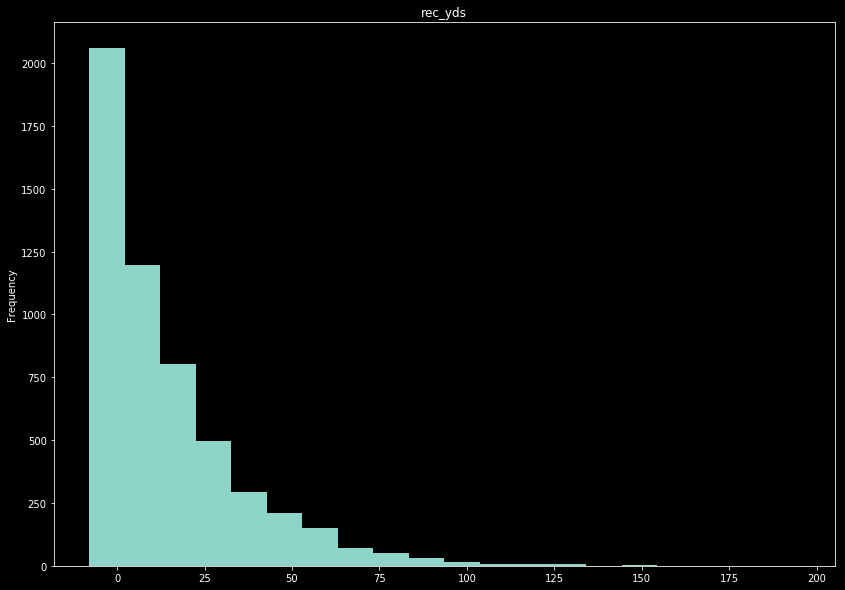

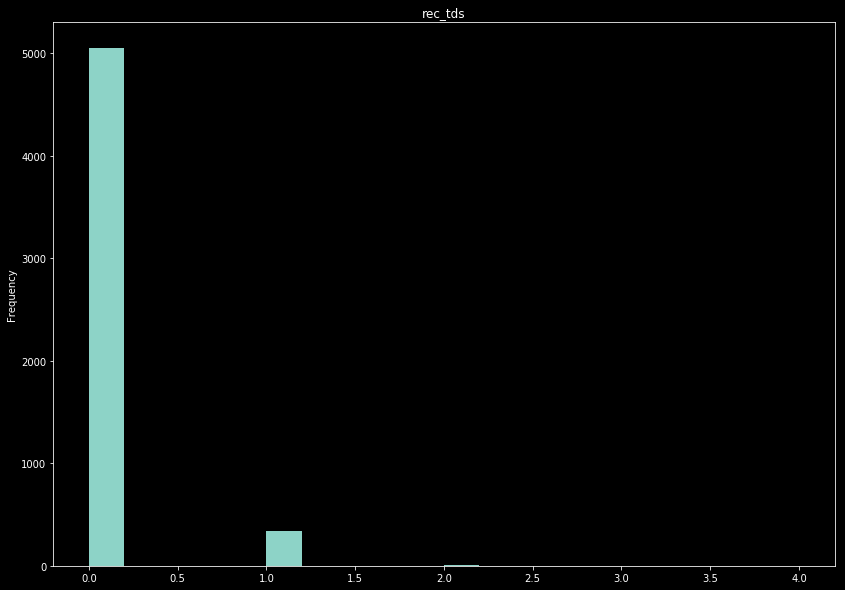

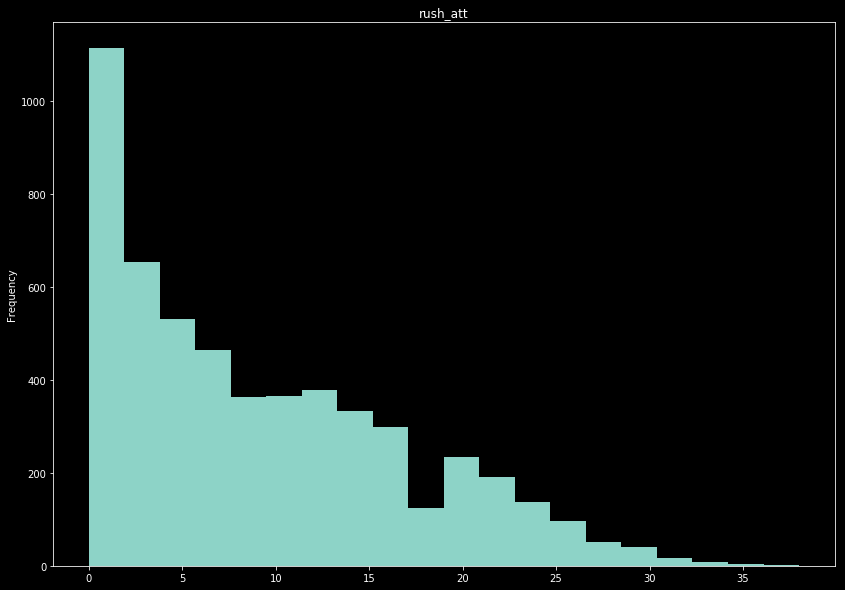

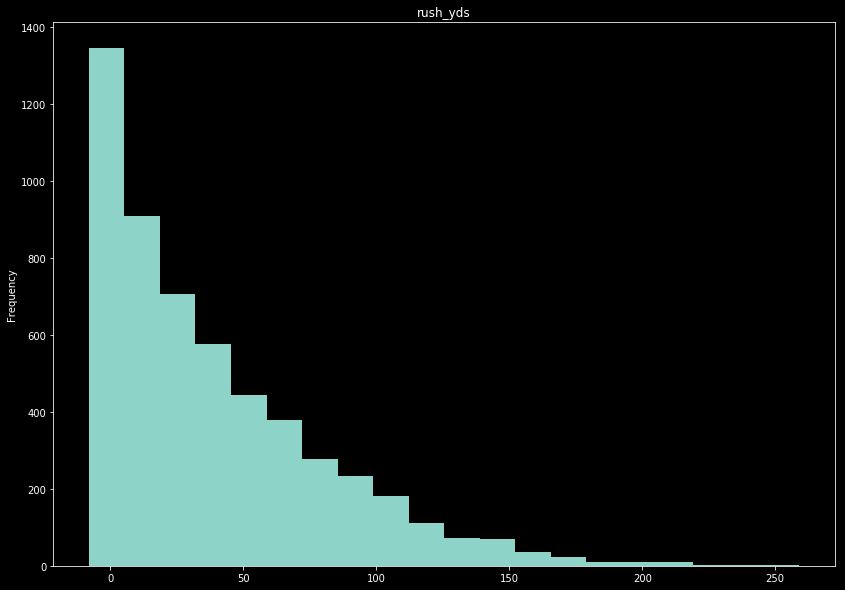

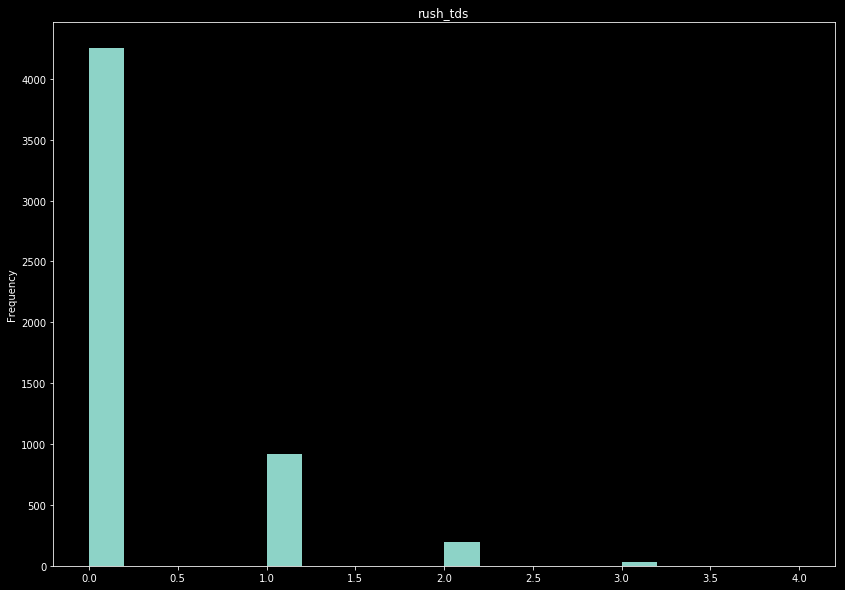

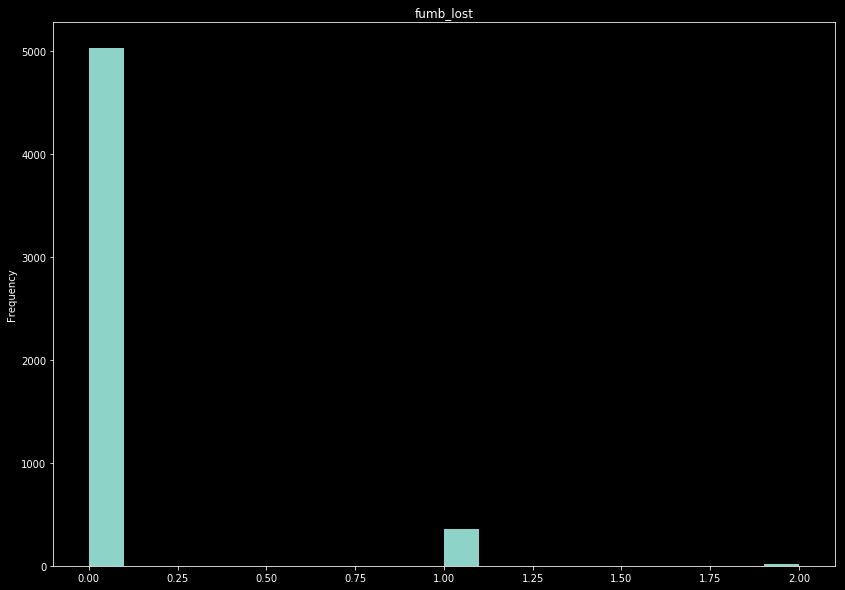

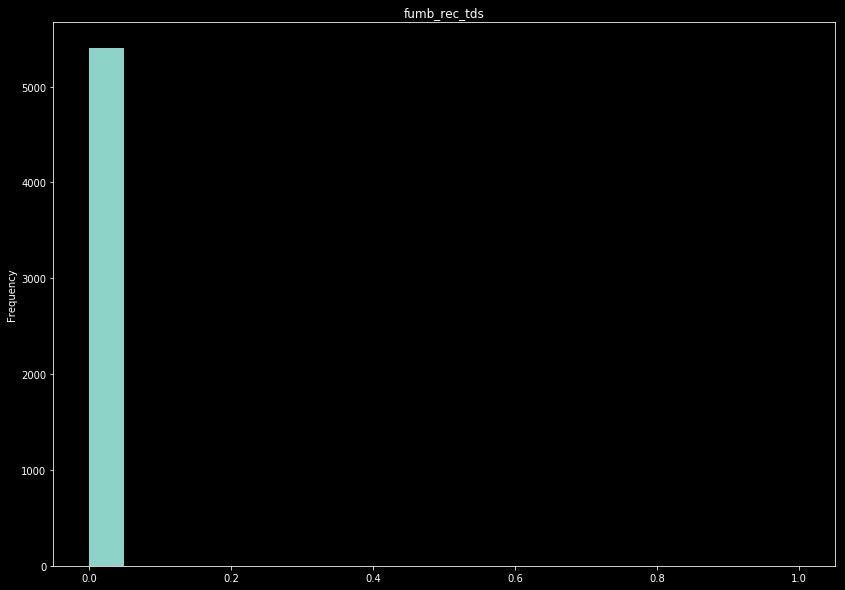

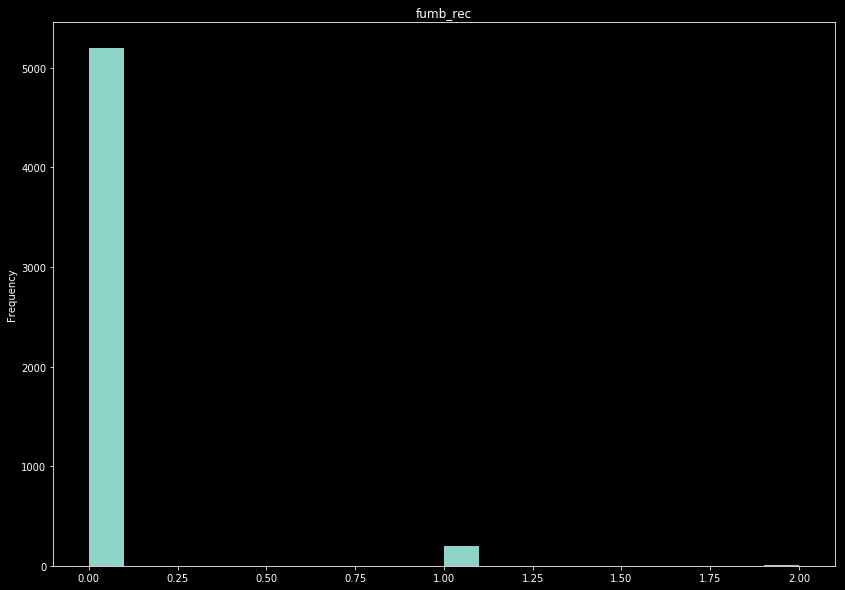

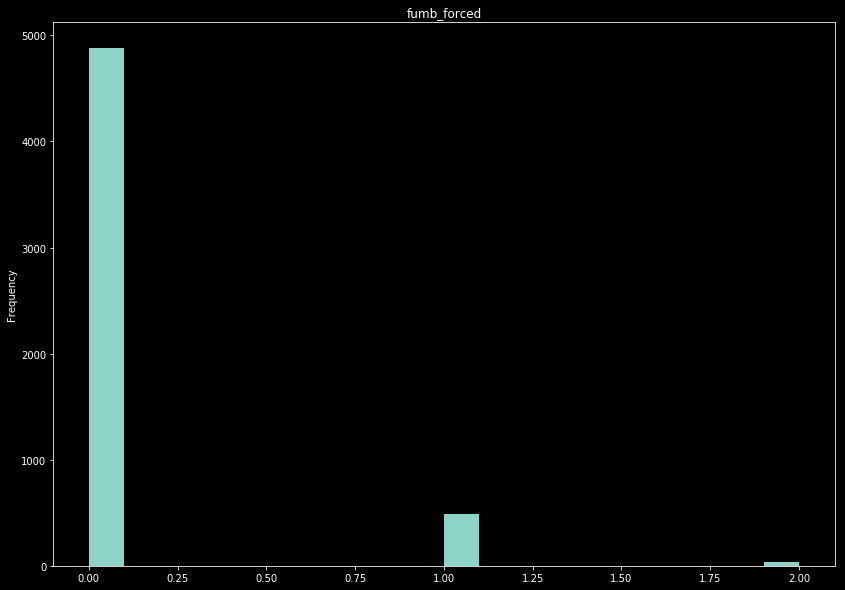

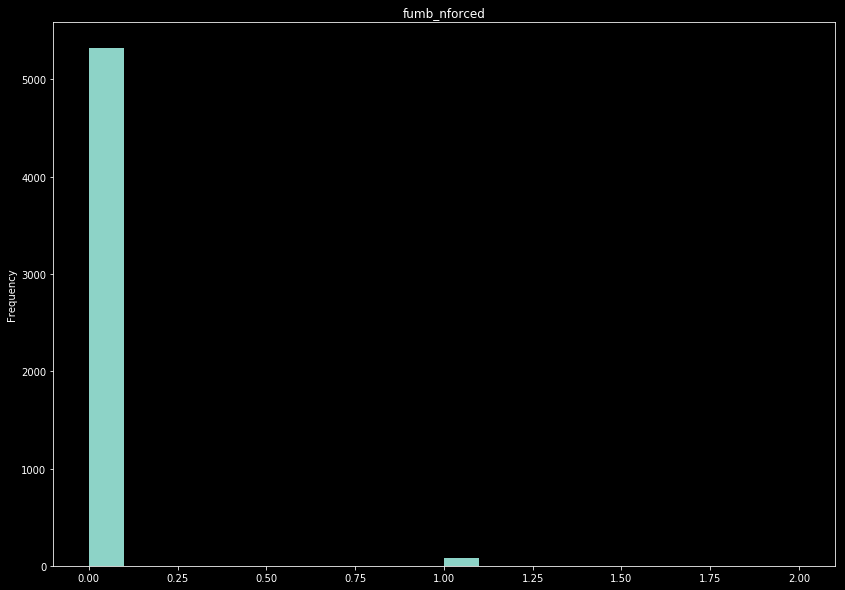

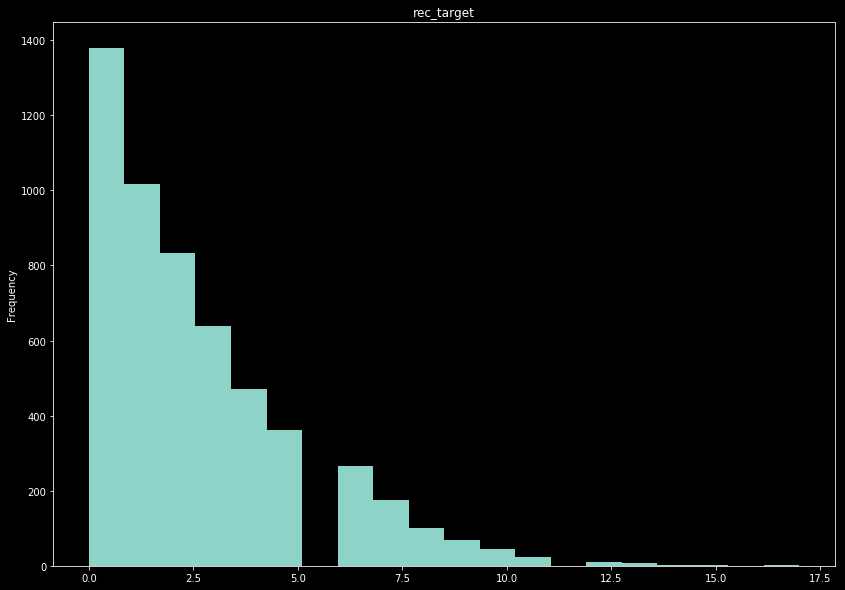

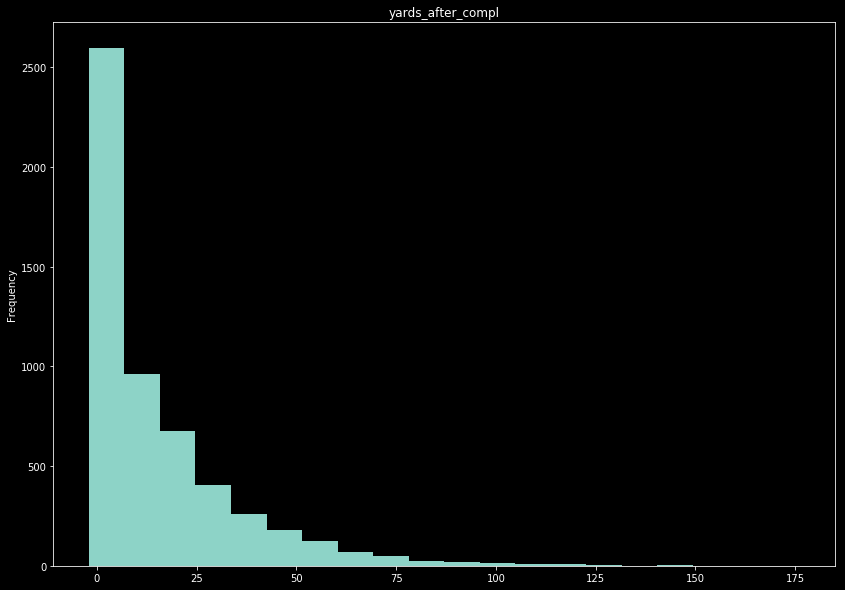

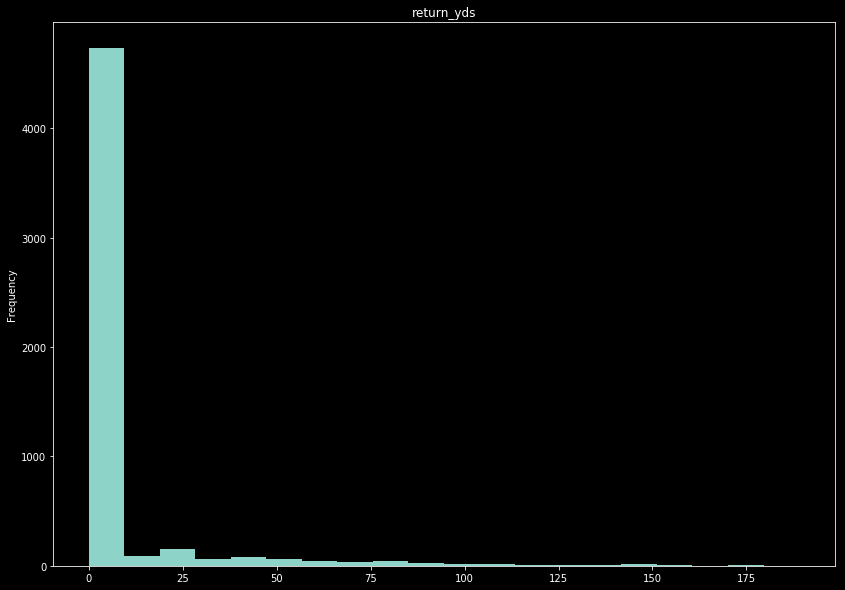

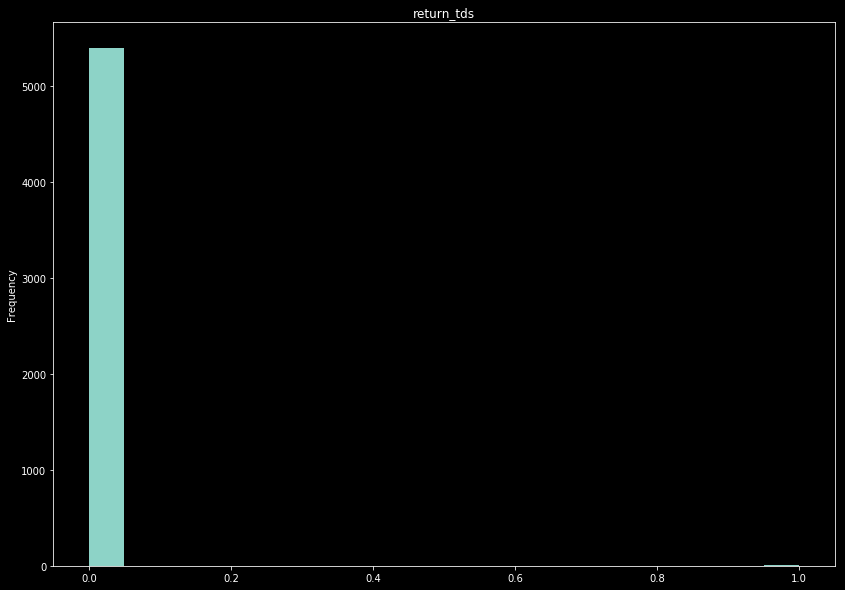

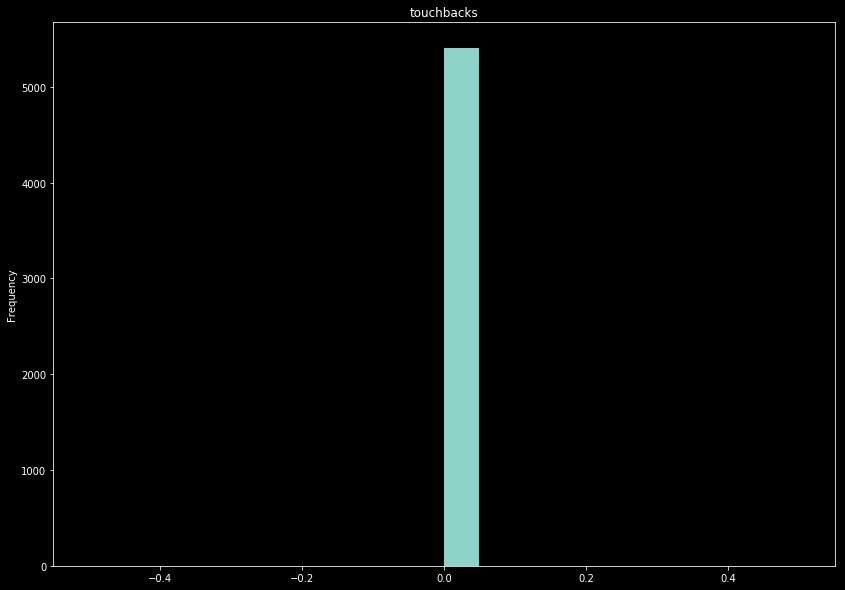

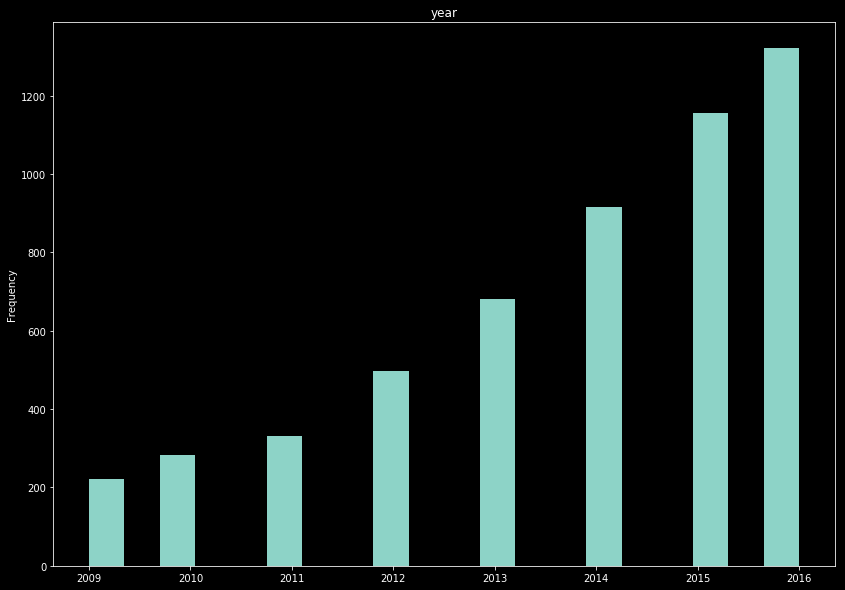

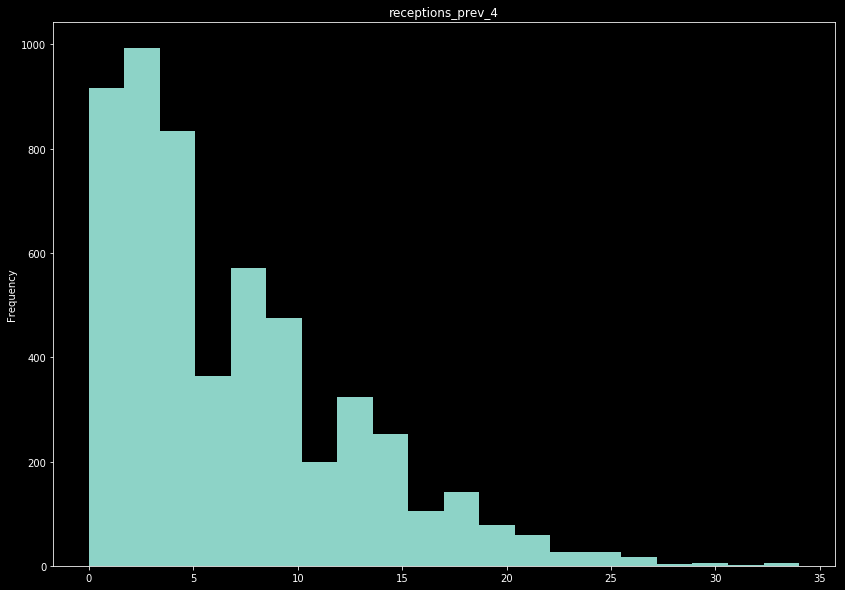

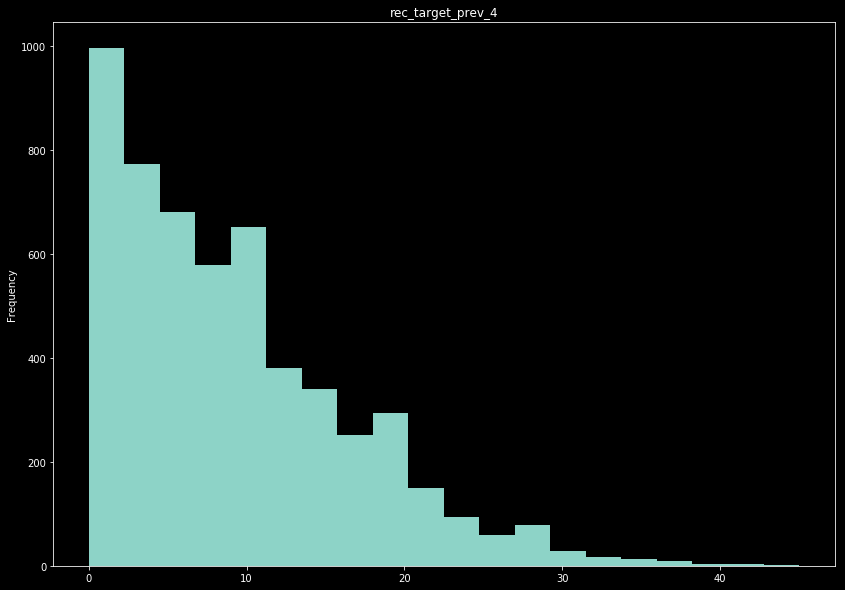

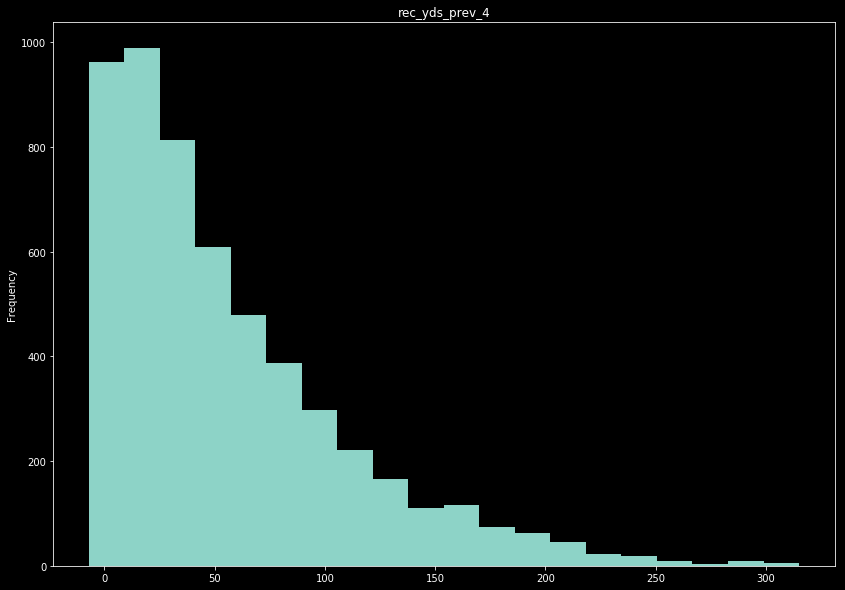

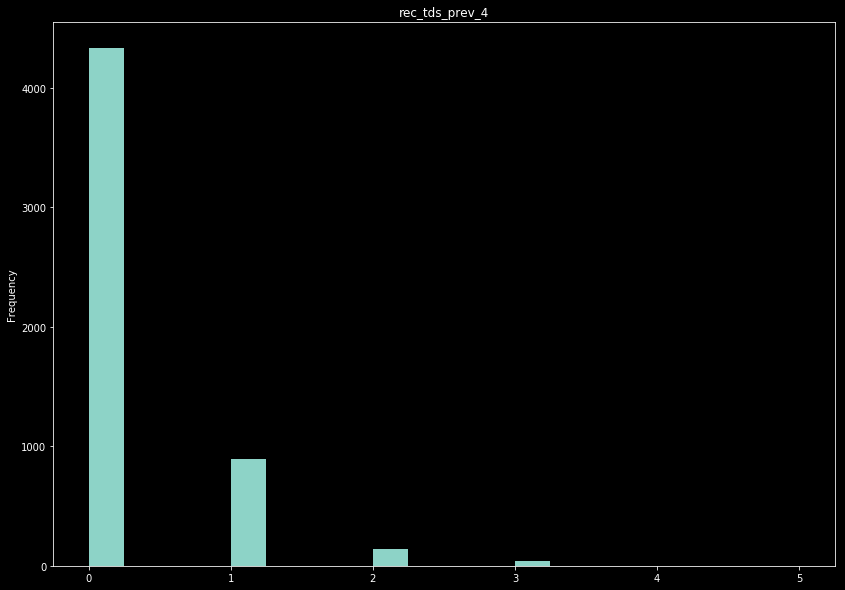

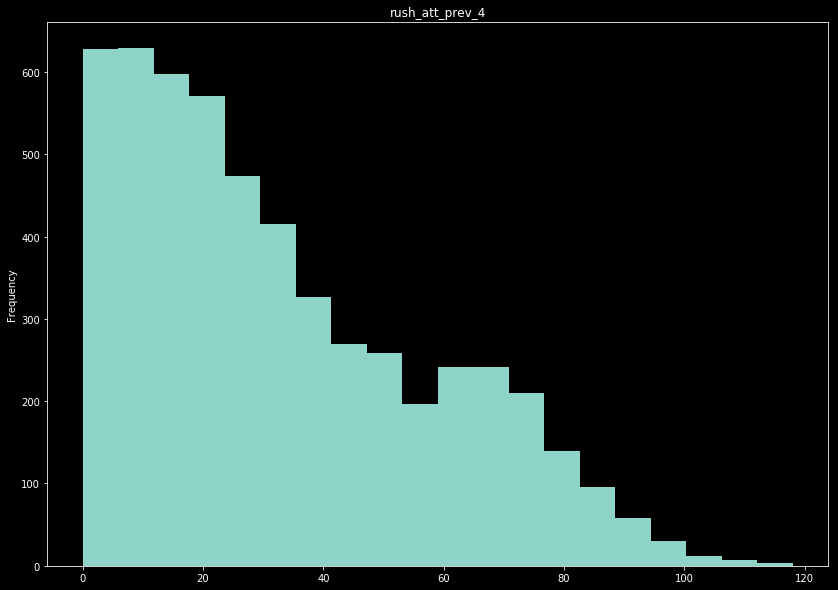

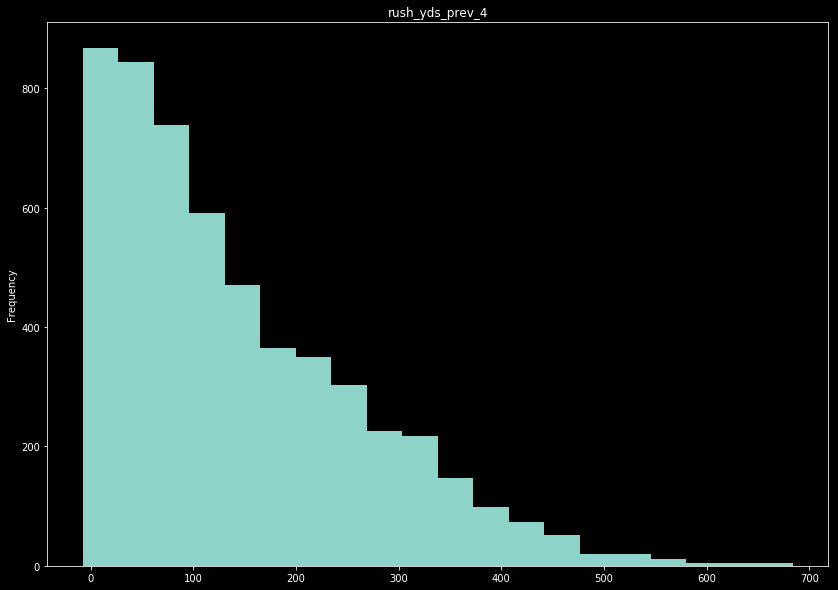

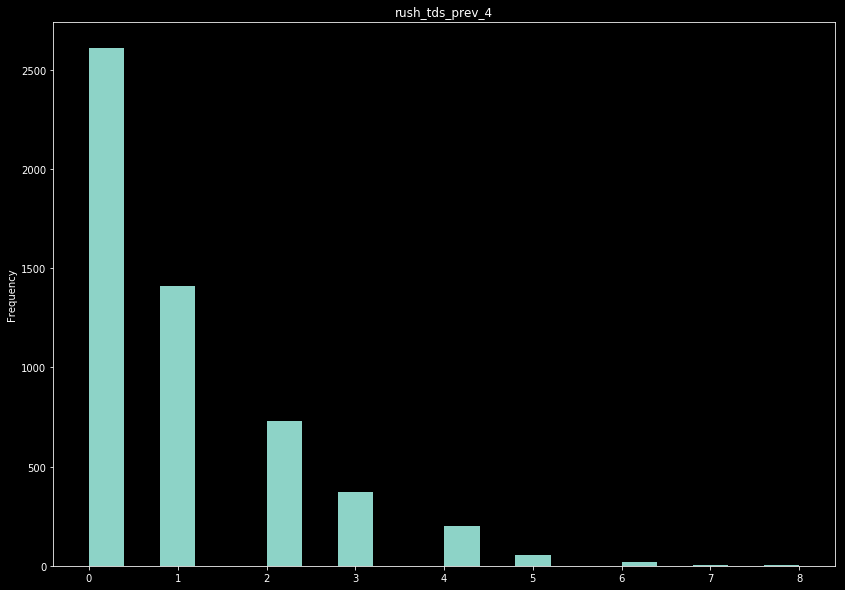

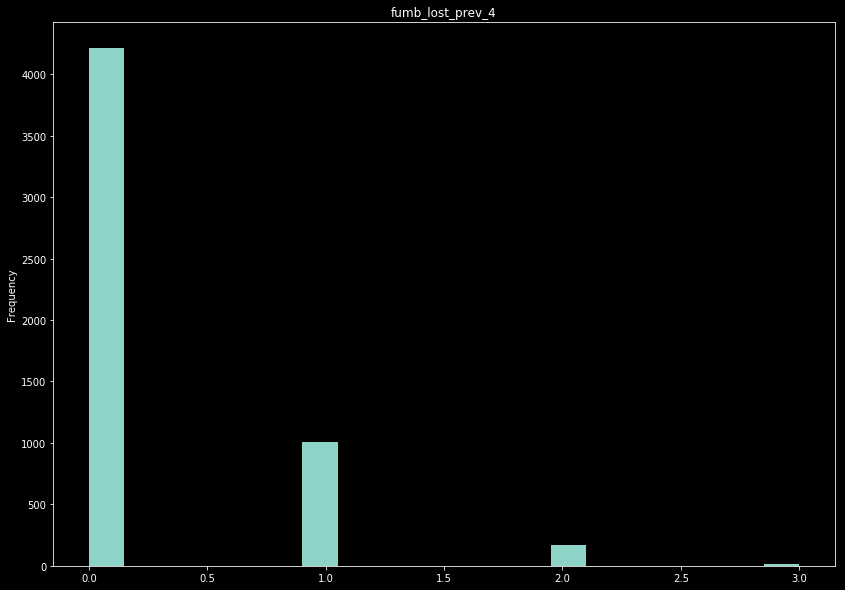

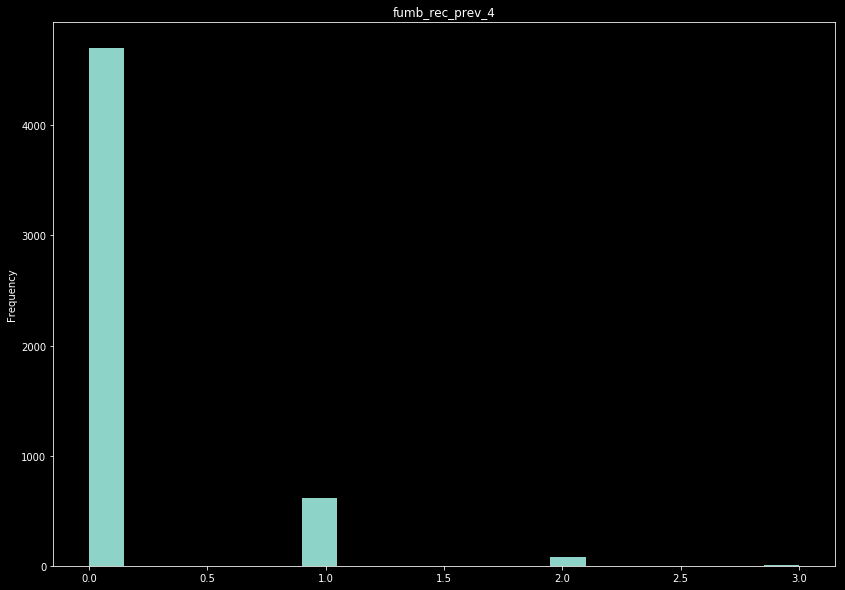

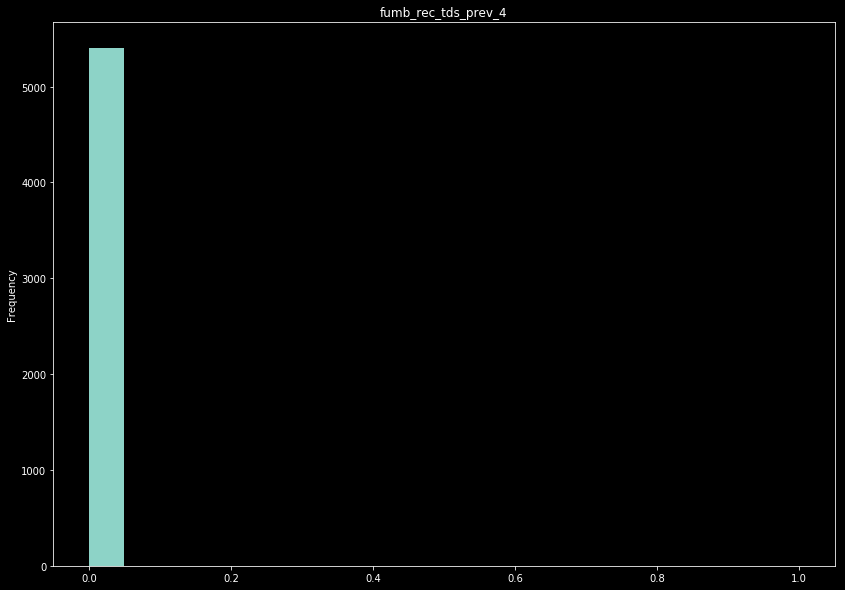

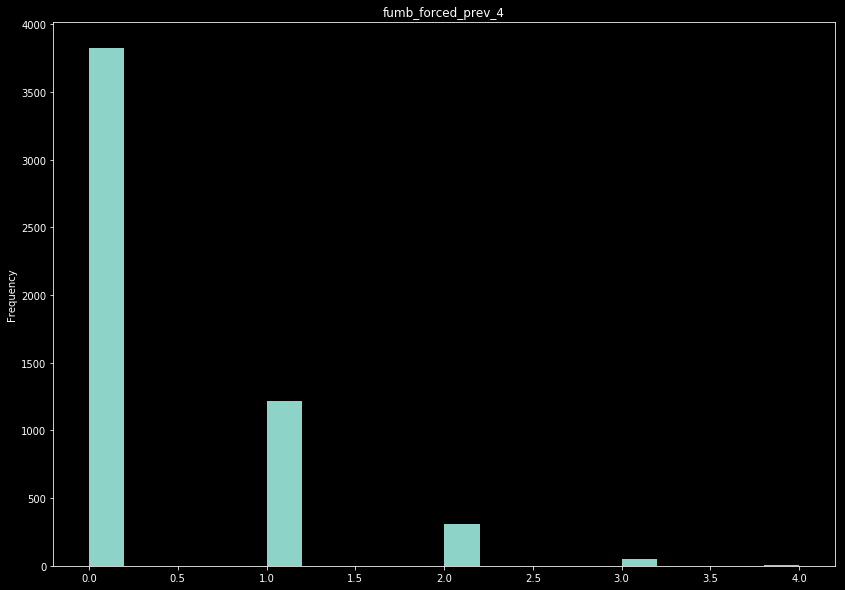

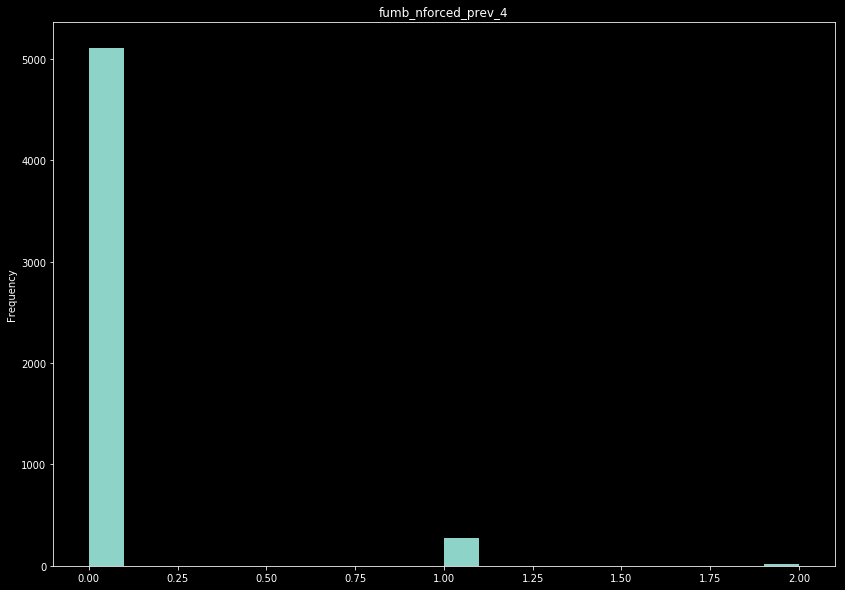

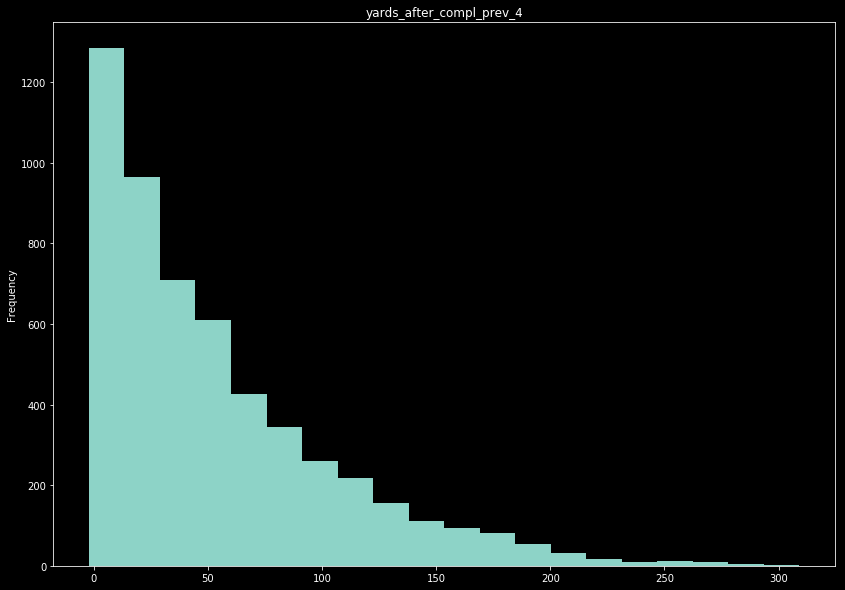

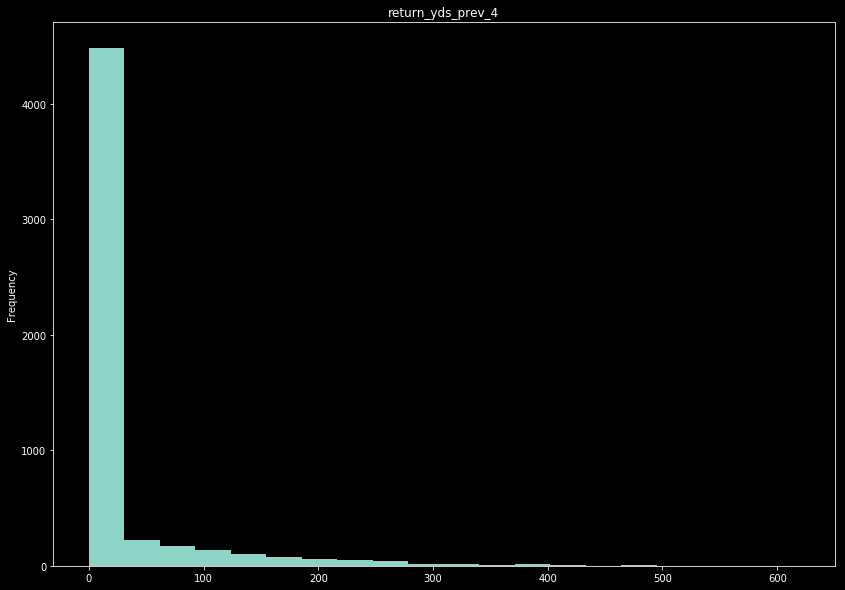

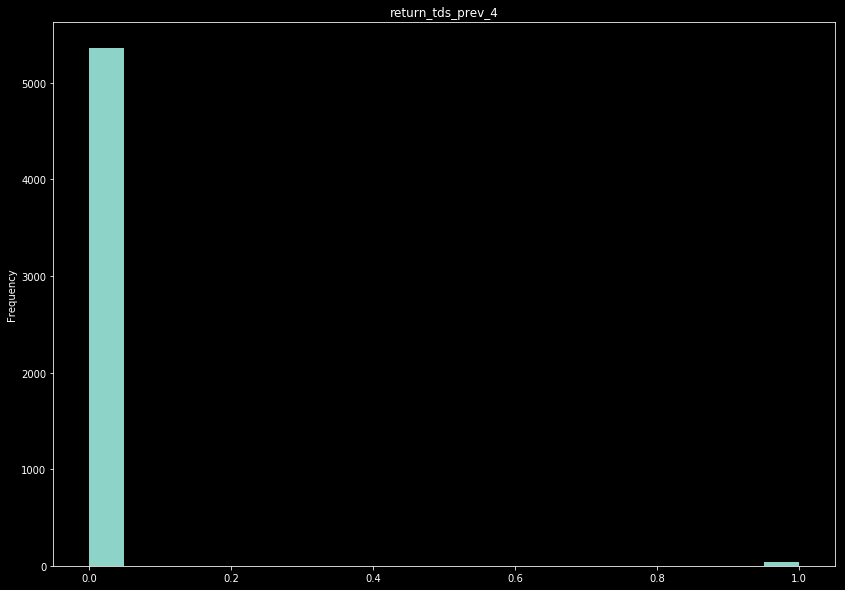

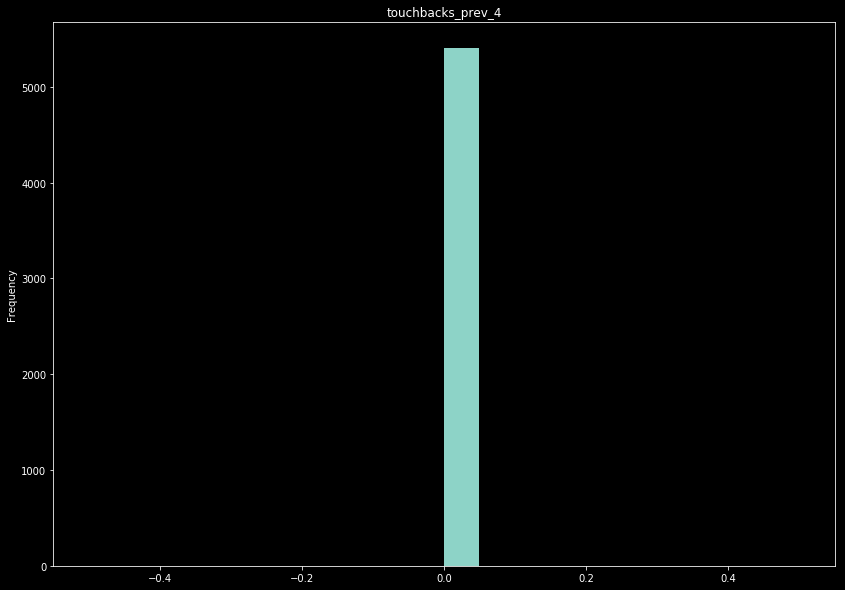

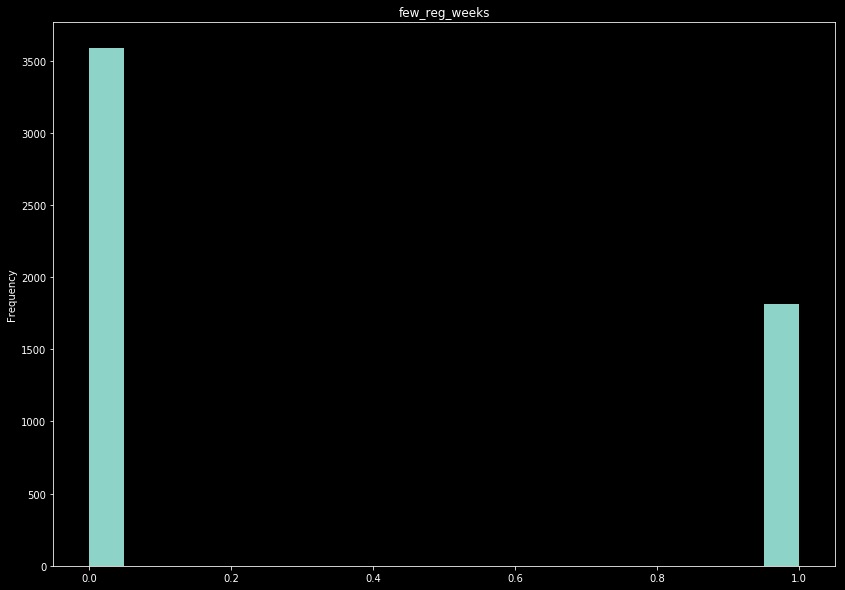

In [14]:
for col in all_rb_data.columns.values[3:]:
    all_rb_data[col].plot.hist(bins=20,title=col)
    plt.show()

Passing Yards: 1 point per 25 yards
    
Passing Touchdowns: 4 points
    
Passing Interceptions: -2 points
    
Rushing Yards: 1 point per 10 yards
    
Rushing Touchdowns: 6 points

Receptions: 1 points (only if using PPR scoring)

Receiving Yards: 1 point per 10 yards

Receiving Touchdowns: 6 points

2-Point Conversions: 2 points

Fumbles Lost: -2 points
    
Fumble Recovered for a Touchdown: 6 points

In [20]:
features = [
             'receptions',
             'rec_yds',
             'rec_tds',
             'rush_yds',
             'rush_tds',
             'fumb_lost',
             'fumb_rec_tds'
           ]

fumbs = [ 'fumb_rec', 'fumb_forced', 'fumb_nforced' ]

misc = [ 'rush_att', 'rec_target', 'yards_after_compl', 'return_yds', 'return_tds', 'touchbacks']

lots = [ 
 'receptions_prev_4', 'rec_target_prev_4', 'rec_yds_prev_4', 'rec_tds_prev_4',
 'rush_att_prev_4', 'rush_yds_prev_4', 'rush_tds_prev_4', 'fumb_lost_prev_4',
 'fumb_rec_prev_4', 'fumb_rec_tds_prev_4', 'fumb_forced_prev_4',
 'fumb_nforced_prev_4', 'yards_after_compl_prev_4', 'return_yds_prev_4',
 'return_tds_prev_4', 'touchbacks_prev_4', 'few_reg_weeks']

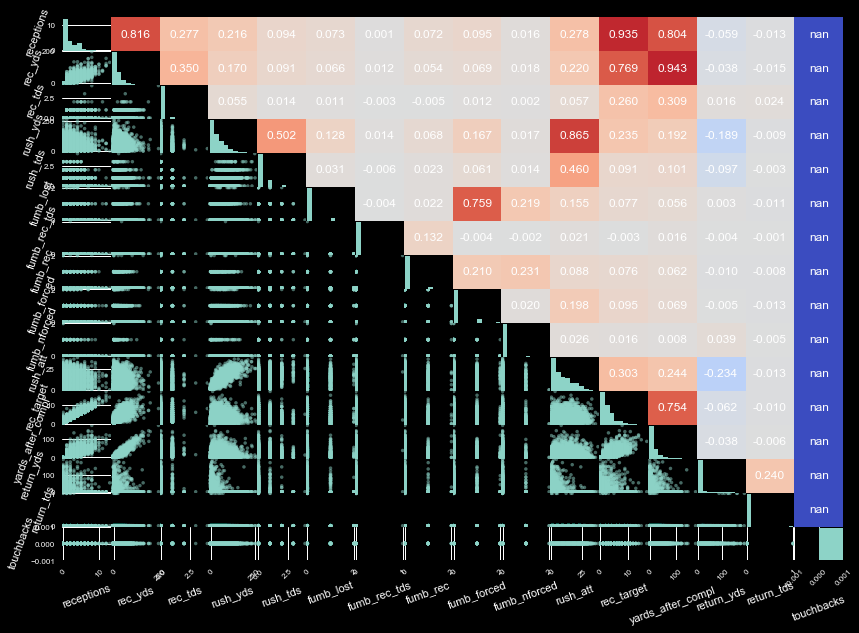

In [21]:
import df_visualizations as dv
plt.style.use('dark_background')
from pylab import rcParams
rcParams['figure.figsize'] = 14, 10

dv.corr_plot( all_rb_data[ features+fumbs+misc ] )

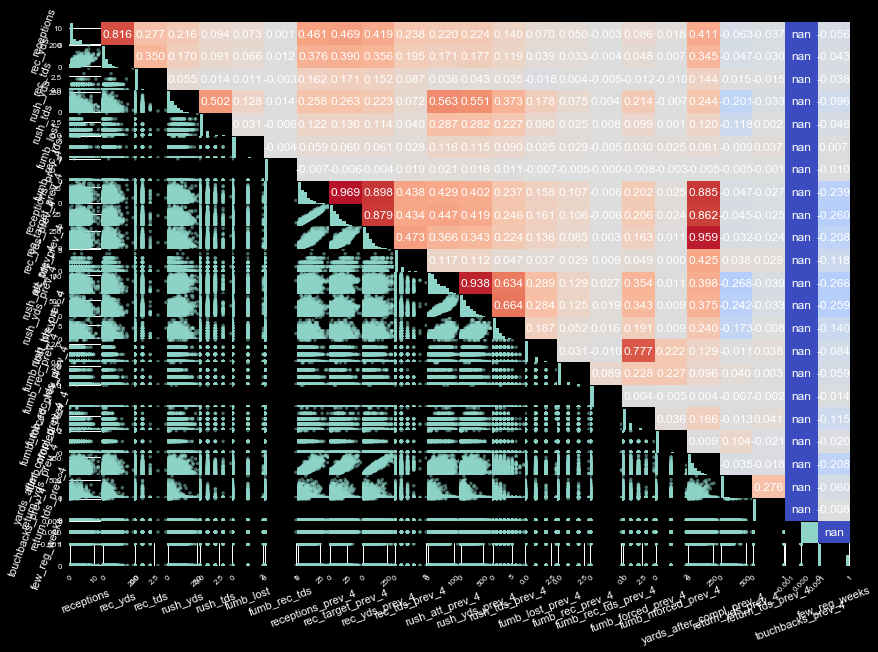

In [22]:
dv.corr_plotrr_plot( all_rb_data[ features+lots] )

In [47]:
team_stats_df.columns.values

array([u'team', 'opp_team', u'week', 'year', 'score', 'opp_score',
       'home_flag', 'away_flag', 'tds', u'rush_att', u'rush_yds',
       u'pass_att', u'pass_yds', u'pass_cmp', u'pass_sack', u'kickoffs',
       u'punts', u'fg_miss', u'kickret_tds', u'punt_ret_tds',
       u'off_fumb_tot', u'kickoff_in_20', u'kickoff_touchback', u'fg_yds',
       u'fg_made', u'def_int_tds', u'def_frec_tds', u'def_misc_tds',
       u'def_safety', u'def_tkl', u'def_tkl_contributers', u'def_fumb_rec',
       u'def_fumb_forced', u'def_int', u'def_tkl_loss', u'def_sack',
       u'def_pass_def', 'score_prev_4', 'opp_score_prev_4',
       'home_flag_prev_4', 'away_flag_prev_4', 'tds_prev_4',
       'rush_att_prev_4', 'rush_yds_prev_4', 'pass_att_prev_4',
       'pass_yds_prev_4', 'pass_cmp_prev_4', 'pass_sack_prev_4',
       'kickoffs_prev_4', 'punts_prev_4', 'fg_miss_prev_4',
       'kickret_tds_prev_4', 'punt_ret_tds_prev_4', 'off_fumb_tot_prev_4',
       'kickoff_in_20_prev_4', 'kickoff_touchback_prev_4',

In [68]:
# Stuff to grab from team df
team_stuff = [ 
               'tds_prev_', 
               'fg_made_prev_', 
               'fg_miss_prev_', 
               'home_flag_prev_', 
               'away_flag_prev_',
               'kickoffs_prev_', 
               'punts_prev_', 
               'rush_att_prev_',
               'pass_att_prev_',
               'rush_yds_prev_',
               'pass_yds_prev_',
             ]

team_stuff = [ item+wk_str for item in team_stuff ]
ttam_stuff = ['team_'+item for item in team_stuff ]

# Stuff to rename from the team frame
team_rn_dict = dict( zip( team_stuff, ttam_stuff ) )

# Rename some more rows
temp_df         = team_stats_df.rename( index=str, columns=team_rn_dict )


temp_frame = pd.merge( 
                       all_rb_data, 
                       temp_df[['team','week','year']+ttam_stuff], 
                       on=['team','week','year']
                     )

In [75]:
# Stuff to grab

team_stuff = [ 
               'team_tds_prev_', 
               'team_fg_made_prev_', 
               'team_fg_miss_prev_', 
               'team_home_flag_prev_', 
               'team_away_flag_prev_',
               'team_kickoffs_prev_', 
               'team_punts_prev_', 
               'team_rush_att_prev_',
               'team_pass_att_prev_',
               'team_rush_yds_prev_',
               'team_pass_yds_prev_',
             ]


reorg_stuff = [
                'receptions_prev_', 'rec_target_prev_', 'rec_yds_prev_', 'rec_tds_prev_', 'yards_after_compl_prev_',
                'rush_att_prev_', 'rush_yds_prev_', 'rush_tds_prev_', 
                'return_yds_prev_', 'return_tds_prev_', 'touchbacks_prev_',

                'fumb_lost_prev_', 'fumb_rec_prev_', 'fumb_rec_tds_prev_', 'fumb_forced_prev_', 'fumb_nforced_prev_', 
              ]

reorg_stuff = [ item+wk_str for item in reorg_stuff ]

# Re-organize the frame
new_frame = temp_frame[[
                        'player_id','team','week','year',
                        'receptions', 'rec_yds', 'rec_tds', 
                        'rush_att', 'rush_yds', 'rush_tds', 
                        'fumb_lost','fumb_rec_tds','few_reg_weeks',
                       ]
                        +reorg_stuff
                        + ttam_stuff
                      ]

In [76]:
new_frame.head()

,player_id,team,week,year,receptions,rec_yds,rec_tds,rush_att,rush_yds,rush_tds,...,team_fg_made_prev_4,team_fg_miss_prev_4,team_home_flag_prev_4,team_away_flag_prev_4,team_kickoffs_prev_4,team_punts_prev_4,team_rush_att_prev_4,team_pass_att_prev_4,team_rush_yds_prev_4,team_pass_yds_prev_4
0,00-0022999,GB,1,2009,0,0,0,0,0,0,...,5.0,5.0,2.0,2.0,22.0,13.0,130.0,111.0,548.0,828.0
1,00-0022999,GB,2,2009,0,0,0,0,0,0,...,6.0,4.0,2.0,2.0,24.0,18.0,105.0,113.0,394.0,842.0
2,00-0022999,GB,3,2009,1,10,1,1,1,1,...,6.0,5.0,2.0,2.0,23.0,19.0,91.0,122.0,375.0,909.0
3,00-0022999,GB,4,2009,0,0,0,2,5,0,...,8.0,3.0,2.0,2.0,23.0,21.0,103.0,121.0,404.0,875.0
4,00-0022999,GB,6,2009,1,1,1,1,2,0,...,7.0,2.0,2.0,2.0,25.0,18.0,94.0,127.0,399.0,1098.0


In [77]:
print new_frame.shape
print new_frame.columns.values

(5403, 40)
[u'player_id' u'team' u'week' 'year' u'receptions' u'rec_yds' u'rec_tds'
 u'rush_att' u'rush_yds' u'rush_tds' u'fumb_lost' u'fumb_rec_tds'
 'few_reg_weeks' 'receptions_prev_4' 'rec_target_prev_4' 'rec_yds_prev_4'
 'rec_tds_prev_4' 'yards_after_compl_prev_4' 'rush_att_prev_4'
 'rush_yds_prev_4' 'rush_tds_prev_4' 'return_yds_prev_4'
 'return_tds_prev_4' 'touchbacks_prev_4' 'fumb_lost_prev_4'
 'fumb_rec_prev_4' 'fumb_rec_tds_prev_4' 'fumb_forced_prev_4'
 'fumb_nforced_prev_4' 'team_tds_prev_4' 'team_fg_made_prev_4'
 'team_fg_miss_prev_4' 'team_home_flag_prev_4' 'team_away_flag_prev_4'
 'team_kickoffs_prev_4' 'team_punts_prev_4' 'team_rush_att_prev_4'
 'team_pass_att_prev_4' 'team_rush_yds_prev_4' 'team_pass_yds_prev_4']


In [22]:
# Generates the QB features
# Mostly previous performance
def generate_rb_features( end_year, n_weeks=4, start_year=2009 ):

    
    min_year = start_year
    max_year = end_year
    wk_str   = str(n_weeks)

    all_rb_data = pd.DataFrame()

    # Get all the preseason data
    # Can id by team, week, year
    for year in range( min_year, max_year ):
        new_frame = gps.generate_stats( 'RB', year, season_type='Preseason' )
        new_frame['year'] = year
        all_rb_data = pd.concat( [all_rb_data, new_frame], ignore_index=True )


    all_rb_data['week'] = all_rb_data['week']-4


    # Get all the RB regular season data
    # Can id by team, week, year
    for year in range( min_year, max_year ):
        new_frame = gps.generate_stats( 'RB', year )
        new_frame['year'] = year
        all_rb_data = pd.concat( [all_rb_data, new_frame], ignore_index=True )


    # Ignore some team stuff, can get from joining with team
    all_rb_data = all_rb_data.drop( ['opp_team','home_flag','away_flag'],axis=1 )

    # Generate previous rolling sum
    agg_stuff = [
                    'receptions',
                    'rec_target', 
                    'rec_yds',
                    'rec_tds', 
                    'rush_att', 
                    'rush_yds', 
                    'rush_tds', 
                    'fumb_lost',
                    'fumb_rec', 
                    'fumb_rec_tds', 
                    'fumb_forced', 
                    'fumb_nforced',
                    'yards_after_compl', 
                    'return_yds', 
                    'return_tds',
                    'touchbacks'
                ]
#aps
    prev_rb = aps.calc_prev_player_stats( all_rb_data, agg_stuff )

    # Combine present values with rolling sums
    all_rb_data = pd.merge( all_rb_data, prev_rb, on=['player_id','year','week'] )

    # Drop all the preseason stuff
    all_rb_data = all_rb_data.loc[ all_rb_data['week']>0 ]

    # Note if the data includes preseason stuff
    # If the first four games, flag as preseason data included
    # This is tricky, as can have a bye-week
    # Therefore, group things, find the first n_weeks, and flag those as 1
    inds = all_rb_data.groupby(['player_id','year'], as_index=False).nth( range(0, n_weeks) ).index.values

    all_rb_data    [       'few_reg_weeks'] = 0
    all_rb_data.loc[ inds, 'few_reg_weeks'] = 1    
    
    
    # Generate team stats
#aps
    team_stats_df = aps.generate_full_team_aggregate( end_year, drop_preseason=False )

    
    # Opposition stuff to grab
    # May have low/hi stats due to tough/weak teams
    opp_agg = ['tds','fg_made','rush_yds','pass_yds','def_tkl_loss','def_sack','def_pass_def']
#aps
    opp_df = aps.calc_opp_avg( team_stats_df, opp_agg )

    
    # Stuff to grab from team df
    team_stuff = [ 
                   'tds_prev_', 
                   'fg_made_prev_', 
                   'fg_miss_prev_', 
                   'home_flag_prev_', 
                   'away_flag_prev_',
                   'kickoffs_prev_', 
                   'punts_prev_',
                   'rush_att_prev_',
                   'pass_att_prev_',
                   'rush_yds_prev_',
                   'pass_yds_prev_',
                 ]

    team_stuff = [ item+wk_str for item in team_stuff ]
    ttam_stuff = ['team_'+item for item in team_stuff ]

    # Stuff to rename from the team frame
    team_rn_dict = dict( zip( team_stuff, ttam_stuff ) )

    # Rename some more rows
    temp_df         = team_stats_df.rename( index=str, columns=team_rn_dict )
    
    
    temp_frame = pd.merge( 
                           all_rb_data, 
                           temp_df[['team','week','year']+ttam_stuff], 
                           on=['team','week','year']
                         )
    
    # Stuff to grab
    reorg_stuff = [
                    'receptions_prev_', 'rec_target_prev_', 'rec_yds_prev_', 'rec_tds_prev_', 'yards_after_compl_prev_',
                    'rush_att_prev_', 'rush_yds_prev_', 'rush_tds_prev_', 
                    'return_yds_prev_', 'return_tds_prev_', 'touchbacks_prev_',

                    'fumb_lost_prev_', 'fumb_rec_prev_', 'fumb_rec_tds_prev_', 'fumb_forced_prev_', 'fumb_nforced_prev_', 
                  ]

    reorg_stuff = [ item+wk_str for item in reorg_stuff ]
    
    # Re-organize the frame
    new_frame = temp_frame[[
                            'player_id','team','week','year',
                            'rush_yds', 'rush_tds',
                            'rec_yds', 'rec_tds', 'receptions',
                            'fumb_lost', 
                            'few_reg_weeks',
                            ]
                            +reorg_stuff
                            +ttam_stuff
                          ]
    

    # Combine opposition stats
    new_frame = pd.merge( new_frame, 
                          opp_df   ,
                          on=['team','week','year'],
                          how='left'
                        )
    
    return new_frame

In [23]:
tits = generate_rb_features(2017)

In [24]:
tits.columns.values

array([u'player_id', u'team', u'week', 'year', u'rush_yds', u'rush_tds',
       u'rec_yds', u'rec_tds', u'receptions', u'fumb_lost',
       'few_reg_weeks', 'receptions_prev_4', 'rec_target_prev_4',
       'rec_yds_prev_4', 'rec_tds_prev_4', 'yards_after_compl_prev_4',
       'rush_att_prev_4', 'rush_yds_prev_4', 'rush_tds_prev_4',
       'return_yds_prev_4', 'return_tds_prev_4', 'touchbacks_prev_4',
       'fumb_lost_prev_4', 'fumb_rec_prev_4', 'fumb_rec_tds_prev_4',
       'fumb_forced_prev_4', 'fumb_nforced_prev_4', 'team_tds_prev_4',
       'team_fg_made_prev_4', 'team_fg_miss_prev_4',
       'team_home_flag_prev_4', 'team_away_flag_prev_4',
       'team_kickoffs_prev_4', 'team_punts_prev_4', 'team_rush_att_prev_4',
       'team_pass_att_prev_4', 'team_rush_yds_prev_4',
       'team_pass_yds_prev_4', 'opp_avg_tds_prev_4',
       'opp_avg_fg_made_prev_4', 'opp_avg_rush_yds_prev_4',
       'opp_avg_pass_yds_prev_4', 'opp_avg_def_tkl_loss_prev_4',
       'opp_avg_def_sack_prev_4', 'op